In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


LATENT_DIM = 256

class VAE(nn.Module):
    # encoder + decoder setup p much verbatim from class slides
    def __init__(self, in_channels=3, latent_dim=1024, hidden_dims=None):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # encoder
        modules = []
        i_channels = in_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(i_channels, out_channels=h_dim,
                        kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            i_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        # decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        modules = []
        hidden_dims.reverse() 

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        # shape fix
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1],
                    out_channels=in_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1),
                nn.Tanh())
        )
        
        self.decoder = nn.Sequential(*modules)

    # lines 24-28 rewrite
    def encode(self, input):
        latent = self.encoder(input)
        latent = torch.flatten(latent, start_dim=1)
        mu = self.fc_mu(latent)
        log_var = self.fc_var(latent)
        return mu, log_var

    # lines 56-58 rewrite
    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2) 
        result = self.decoder(result)
        return result

    # forward pass combine enc + dec
    def forward(self, input):
        mu, log_var = self.encode(input)
        # "reparameterization trick" 
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps * std + mu
        recons = self.decode(z)
        return recons, input, mu, log_var

# loss function
# https://medium.com/@bhipanshudhupar/loss-functions-in-simple-autoencoders-mse-vs-l1-loss-4e838ae425b9 suggest using L1
def loss(reconst, img, mu, log_var):
    #recons_loss = F.mse_loss(reconst, img)
    recons_loss = F.l1_loss(reconst, img)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
    loss = recons_loss + 0.001 * kld_loss
    return loss


In [2]:
from ignite.metrics import FID, InceptionScore
import ignite.distributed as idist
from ignite.engine import Engine
from torchvision import transforms

image_size = 64
data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.Lambda(lambda i: i.split()[0]), # just grab first channel
        # as it looks like all channels are equal already
        #transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]
)

fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

train = ImageFolder(root="C:/Users/Steam/Documents/ece285-hw2/chest_xray/train", transform = data_transform)
test = ImageFolder(root="C:/Users/Steam/Documents/ece285-hw2/chest_xray/test", transform = data_transform)

import PIL.Image as Image




In [3]:
from torchvision.transforms import v2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 256
LEARNING_RATE = 0.0005
EPOCHS = 100

model = VAE(in_channels = 1, latent_dim = LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)

# modified from
# https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is
def interpolate(batch):
    # arr = []
    '''
    for img in batch:
        # il_img = transforms.ToPILImage()(img * 0.5 + 0.5) # unnormalize

        pil_img = transforms.ToPILImage()(img) 
        resized_img = pil_img.resize((299,299), Image.BILINEAR)

        #resized_img = v2.RGB()(resized_img) 
        
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)
    '''
    resized = F.interpolate(batch * 0.5 + 0.5, size=(299, 299), mode='bilinear', align_corners=False)
    return resized.expand(-1, 3, -1, -1)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch[0].size(0), LATENT_DIM, device=idist.device())
        model.eval()
        fake_batch = model.decode(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real
    
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

loss_values = []
fid_values = []
is_values = []

trainloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

Using device: cuda


In [ ]:
print("Starting training...")
for epoch in range(EPOCHS): #EPOCHS
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        
        recons, inputs, mu, log_var = model(data)
        
        loss_ = loss(recons, inputs, mu, log_var)
        
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
        
        total_loss += loss_.item()
        if batch_idx % 10 == 0:
            print(f"{batch_idx} of {len(trainloader)}")
    
    avg_loss = total_loss / len(trainloader)
    loss_values.append(avg_loss)
        
    print(f"Epoch {epoch}/{EPOCHS} | Loss: {avg_loss:.6f}")

    evaluator.run(testloader, max_epochs=1)
    metrics = evaluator.state.metrics
    fid_values.append(metrics["fid"])
    is_values.append(metrics["is"])
    scheduler.step()

print("Training complete.")

Starting training...
0 of 21
10 of 21
20 of 21
Epoch 0/100 | Loss: 0.108808
0 of 21
10 of 21
20 of 21
Epoch 1/100 | Loss: 0.109087
0 of 21
10 of 21
20 of 21
Epoch 2/100 | Loss: 0.108871
0 of 21
10 of 21
20 of 21
Epoch 3/100 | Loss: 0.108865
0 of 21
10 of 21
20 of 21
Epoch 4/100 | Loss: 0.108436
0 of 21
10 of 21
20 of 21
Epoch 5/100 | Loss: 0.108720
0 of 21
10 of 21
20 of 21
Epoch 6/100 | Loss: 0.109241
0 of 21
10 of 21
20 of 21
Epoch 7/100 | Loss: 0.108837
0 of 21
10 of 21
20 of 21
Epoch 8/100 | Loss: 0.108640
0 of 21
10 of 21
20 of 21
Epoch 9/100 | Loss: 0.108607
0 of 21
10 of 21
20 of 21
Epoch 10/100 | Loss: 0.108907
0 of 21
10 of 21
20 of 21
Epoch 11/100 | Loss: 0.108831
0 of 21
10 of 21
20 of 21
Epoch 12/100 | Loss: 0.108912
0 of 21
10 of 21
20 of 21
Epoch 13/100 | Loss: 0.108634
0 of 21
10 of 21
20 of 21
Epoch 14/100 | Loss: 0.108775
0 of 21
10 of 21
20 of 21
Epoch 15/100 | Loss: 0.109171
0 of 21
10 of 21
20 of 21
Epoch 16/100 | Loss: 0.108594
0 of 21
10 of 21
20 of 21
Epoch 17/10

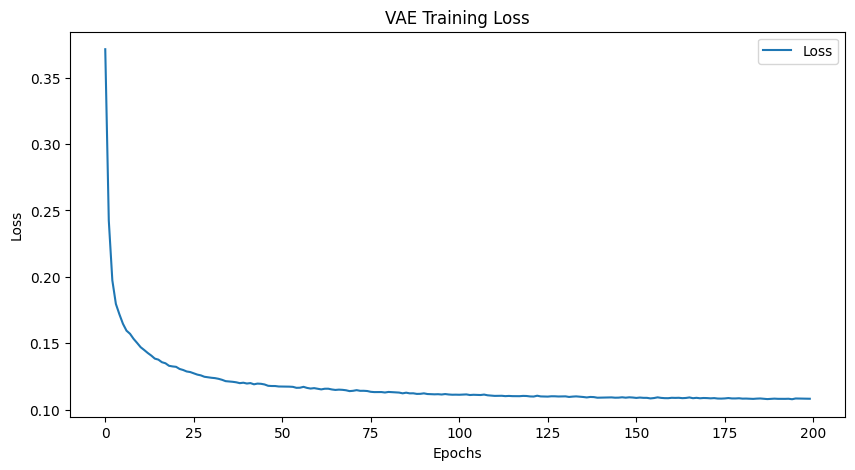

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("VAE Training Loss")
plt.plot(loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

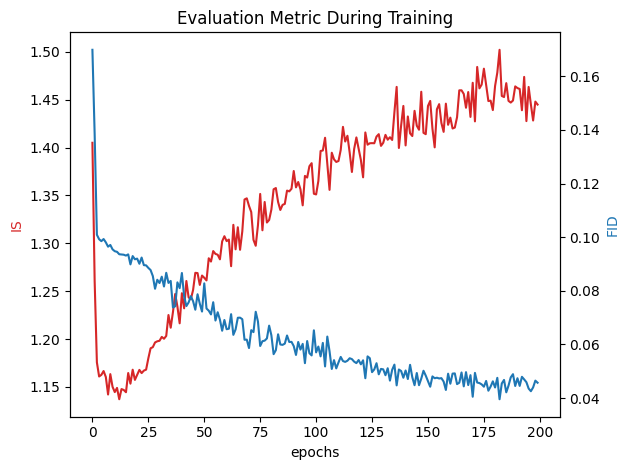

In [23]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()


In [24]:

import numpy as np
import torchvision.utils as vutils

In [25]:
noise = torch.randn(9, LATENT_DIM, device=idist.device())
model.eval()
fake = model.decode(noise)

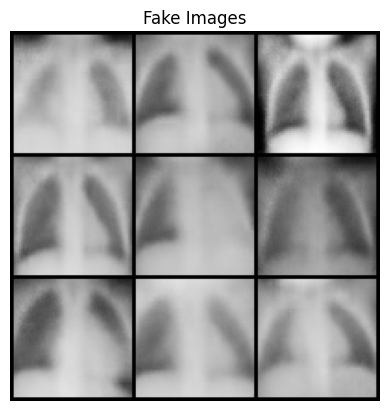

In [26]:
plt.figure()
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.expand(-1, 3, -1, -1), padding=2, normalize=True, nrow=3).cpu(), (1,2,0)))

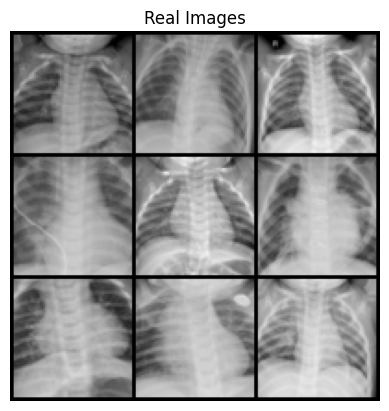

In [27]:
plt.figure()
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(data[0:9].expand(-1, 3, -1, -1), padding=2, normalize=True, nrow=3).cpu(), (1,2,0)))

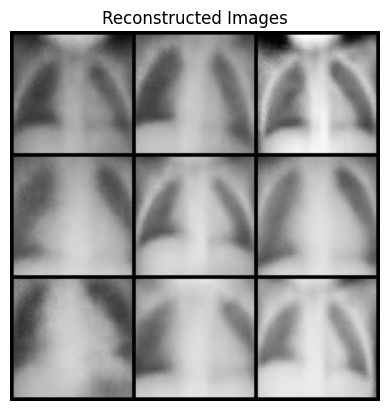

In [28]:
model.eval()
recons, inputs, mu, log_var = model(data[0:9])
plt.figure()
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(vutils.make_grid(recons.expand(-1, 3, -1, -1), padding=2, normalize=True, nrow=3).cpu(), (1,2,0)))